In [1]:
from parameters import get_parameters
from pathlib import Path
import ee
import geemap
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
params = get_parameters()

start_year = params["start_year"]
end_year = params["end_year"]
DATE_START = f"{start_year}-01-01"
DATE_END   = f"{end_year}-12-31"

# Definir variables climáticas (nombres originales de ERA5)
VARIABLES = ["temperature_2m",
            "surface_runoff",
            "u_component_of_wind_10m",
            "v_component_of_wind_10m",
            "total_precipitation"
            ]

# Definir nombres simplificados para columnas y archivos
VARIABLE_NAMES = ["temperature",
                 "runoff",
                 "u_wind",
                 "v_wind",
                 "precipitation"
                 ]

source_curated = params["source_curated"]

In [3]:
ee.Authenticate(auth_mode='notebook')
ee.Initialize(project='ee-danielanino419')

In [4]:
PROJECT_ROOT = Path().resolve().parent
print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Users\dxnin\OneDrive\Documentos\dengue-forecast


In [5]:
# Definir colección ERA5 hourly (todas las variables)
era5 = (
    ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
    .filterDate('2025-01-01', '2025-01-02')
    .filter(ee.Filter.calendarRange(17, 20, "hour"))
    .select(VARIABLES)
)

   COD_MPIO MPIO_NOMBR        SUBREGION  ALERTA DESCRIPCI SymbolID  \
95    05001   MEDELLÍN  VALLE DE ABURRA       0      None     None   

                                             geometry  
95  POLYGON ((-75.66873 6.37315, -75.66963 6.37359...  


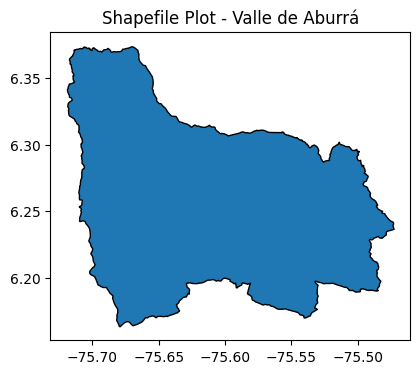

In [6]:
# Leer shapefile y filtrar municipios
shapefile_path = f"{PROJECT_ROOT}/data/municipios/municipios_.shp"
gdf = gpd.read_file(shapefile_path)
gdf = gdf[gdf['MPIO_NOMBR'].isin(['MEDELLÍN'])]

# Convertir municipios a latitud y longitud
gdf_latlon = gdf.to_crs(epsg=4326)
print(gdf_latlon.head())

# Dibujar shapefile
gdf_latlon.plot(figsize=(5, 4), edgecolor="black")
plt.title("Shapefile Plot - Valle de Aburrá")
plt.show()

In [7]:
# Crear una imagen representativa
era5_ref = era5.mean().select(VARIABLES[0])

# Muestrear a resolución nativa de ERA5 (~9 km)
era5_sample = era5_ref.sample(
    region=gdf_latlon.union_all().__geo_interface__,
    scale=10000,
    geometries=True
)

In [8]:
# Convertir a GeoDataFrame
points_with_municipio = geemap.ee_to_gdf(era5_sample)
points_with_municipio = gpd.sjoin(points_with_municipio, gdf_latlon, how="left", predicate="within")
print(f"Se generaron {len(points_with_municipio)} puntos de la grilla ERA5")

Se generaron 4 puntos de la grilla ERA5


In [9]:
# Mantener solo columnas relevantes
points_with_municipio = points_with_municipio[['geometry', 'MPIO_NOMBR']].reset_index().rename(columns={"index": "id"})
points_with_municipio.head()

,id,geometry,MPIO_NOMBR
0,0,POINT (-75.68306 6.24329),MEDELLÍN
1,1,POINT (-75.59323 6.24329),MEDELLÍN
2,2,POINT (-75.5034 6.24329),MEDELLÍN
3,3,POINT (-75.68306 6.33312),MEDELLÍN


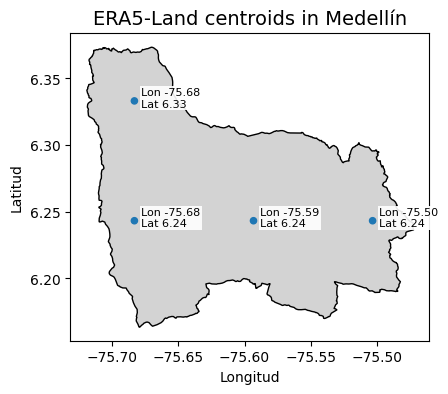

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))
gdf_latlon.plot(ax=ax, facecolor="lightgray", edgecolor="black")

points_with_municipio.plot(
    ax=ax,
    column="MPIO_NOMBR",
    categorical=True,
    markersize=20,
    zorder=5
)

for idx, row in points_with_municipio.iterrows():
    lon = row.geometry.x
    lat = row.geometry.y
    ax.text(
        lon + 0.005,
        lat + 0.002,
        f"Lon {lon:.2f}\nLat {lat:.2f}",
        fontsize=8,
        color="black",
        ha="left",
        va="center",
        bbox=dict(facecolor="white", alpha=0.9, edgecolor="none", pad=1)
    )

plt.title("ERA5-Land centroids in Medellín", fontsize=14)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [11]:
# Convertir punto a Earth Engine Features
def gdf_to_fc(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = row["geometry"]
        ee_point = ee.Geometry.Point([geom.x, geom.y])
        feat = ee.Feature(ee_point, {"id": row["id"], "MPIO_NOMBR": row["MPIO_NOMBR"]})
        features.append(feat)
    return ee.FeatureCollection(features)

fc_points = gdf_to_fc(points_with_municipio)

In [12]:
# Procesar todas las variables climáticas
def select_band(img):
    return img.set({
        "datetime_utc": img.date().format("YYYY-MM-dd HH:mm"),
        "system:time_start": img.get("system:time_start")
    })

In [13]:
# Extraer todas las variables climáticas en los puntos
def extract_climate_data(img):
    values = img.sampleRegions(
        collection=fc_points,
        scale=10000,
        geometries=True
    )
    return values.map(lambda f: f.set("datetime_utc", img.get("datetime_utc")))

In [14]:
weeks = pd.date_range(start=DATE_START, end=DATE_END, freq="W")

results = []

for i in range(int(len(weeks)/2)):
    start = weeks[i].strftime("%Y-%m-%d")
    end   = weeks[i+1].strftime("%Y-%m-%d")

    print(f"Procesando semana: {start} -> {end}")

    # Filtrar datos ERA5 en la ventana semanal
    era5_week = (
        ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
        .filterDate(start, end)
        .filter(ee.Filter.calendarRange(17, 20, "hour"))
        .select(VARIABLES)
    )

    if era5_week.size().getInfo() == 0:
        print("  No hay datos en esta semana.")
        continue

    # Procesar todas las variables climáticas
    climate_data = era5_week.map(select_band)

    # Extraer todas las variables en puntos
    extracted = climate_data.map(extract_climate_data).flatten()

    # Convertir a GeoDataFrame
    gdf_results = geemap.ee_to_gdf(extracted)

    results.append(gdf_results)

Procesando semana: 2007-01-07 -> 2007-01-14
Procesando semana: 2007-01-14 -> 2007-01-21
Procesando semana: 2007-01-21 -> 2007-01-28
Procesando semana: 2007-01-28 -> 2007-02-04
Procesando semana: 2007-02-04 -> 2007-02-11
Procesando semana: 2007-02-11 -> 2007-02-18
Procesando semana: 2007-02-18 -> 2007-02-25
Procesando semana: 2007-02-25 -> 2007-03-04
Procesando semana: 2007-03-04 -> 2007-03-11
Procesando semana: 2007-03-11 -> 2007-03-18
Procesando semana: 2007-03-18 -> 2007-03-25
Procesando semana: 2007-03-25 -> 2007-04-01
Procesando semana: 2007-04-01 -> 2007-04-08
Procesando semana: 2007-04-08 -> 2007-04-15
Procesando semana: 2007-04-15 -> 2007-04-22
Procesando semana: 2007-04-22 -> 2007-04-29
Procesando semana: 2007-04-29 -> 2007-05-06
Procesando semana: 2007-05-06 -> 2007-05-13
Procesando semana: 2007-05-13 -> 2007-05-20
Procesando semana: 2007-05-20 -> 2007-05-27
Procesando semana: 2007-05-27 -> 2007-06-03
Procesando semana: 2007-06-03 -> 2007-06-10
Procesando semana: 2007-06-10 ->

In [15]:
for i in range(int(len(weeks)/2), len(weeks) - 1):
    start = weeks[i].strftime("%Y-%m-%d")
    end   = weeks[i+1].strftime("%Y-%m-%d")

    print(f"Procesando semana: {start} -> {end}")

    # Filtrar datos ERA5 en la ventana semanal
    era5_week = (
        ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
        .filterDate(start, end)
        .filter(ee.Filter.calendarRange(17, 20, "hour"))
        .select(VARIABLES)
    )

    if era5_week.size().getInfo() == 0:
        print("  No hay datos en esta semana.")
        continue

    # Procesar todas las variables climáticas
    climate_data = era5_week.map(select_band)

    # Extraer todas las variables en puntos
    extracted = climate_data.map(extract_climate_data).flatten()

    # Convertir a GeoDataFrame
    gdf_results = geemap.ee_to_gdf(extracted)

    results.append(gdf_results)

Procesando semana: 2015-07-05 -> 2015-07-12
Procesando semana: 2015-07-12 -> 2015-07-19
Procesando semana: 2015-07-19 -> 2015-07-26
Procesando semana: 2015-07-26 -> 2015-08-02
Procesando semana: 2015-08-02 -> 2015-08-09
Procesando semana: 2015-08-09 -> 2015-08-16
Procesando semana: 2015-08-16 -> 2015-08-23
Procesando semana: 2015-08-23 -> 2015-08-30
Procesando semana: 2015-08-30 -> 2015-09-06
Procesando semana: 2015-09-06 -> 2015-09-13
Procesando semana: 2015-09-13 -> 2015-09-20
Procesando semana: 2015-09-20 -> 2015-09-27
Procesando semana: 2015-09-27 -> 2015-10-04
Procesando semana: 2015-10-04 -> 2015-10-11
Procesando semana: 2015-10-11 -> 2015-10-18
Procesando semana: 2015-10-18 -> 2015-10-25
Procesando semana: 2015-10-25 -> 2015-11-01
Procesando semana: 2015-11-01 -> 2015-11-08
Procesando semana: 2015-11-08 -> 2015-11-15
Procesando semana: 2015-11-15 -> 2015-11-22
Procesando semana: 2015-11-22 -> 2015-11-29
Procesando semana: 2015-11-29 -> 2015-12-06
Procesando semana: 2015-12-06 ->

In [16]:
# Concatenar todas las semanas
df_climate = pd.concat(results, ignore_index=True)

# Mostrar df_climate
df_climate.head(100)

,geometry,MPIO_NOMBR,datetime_utc,id,surface_runoff,temperature_2m,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07 17:00,0,0.000012,294.085724,0.000227,-0.079910,0.769592
1,POINT (-75.62085 6.2821),MEDELLÍN,2007-01-07 17:00,1,0.000037,292.736115,0.000390,-0.212723,0.708069
2,POINT (-75.53102 6.2821),MEDELLÍN,2007-01-07 17:00,2,0.000062,293.374786,0.000690,-0.701004,0.472717
3,POINT (-75.71068 6.37193),MEDELLÍN,2007-01-07 17:00,3,0.000002,295.200958,0.000196,-0.153152,0.705139
4,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07 18:00,0,0.000025,294.764664,0.000477,0.002228,0.799057
...,...,...,...,...,...,...,...,...,...
95,POINT (-75.71068 6.37193),MEDELLÍN,2007-01-12 20:00,3,0.000013,296.599915,0.001118,-0.042877,0.558151
96,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-13 17:00,0,0.000012,294.034149,0.000237,-0.220276,0.489456
97,POINT (-75.62085 6.2821),MEDELLÍN,2007-01-13 17:00,1,0.000017,292.588837,0.000188,-0.381409,0.422073
98,POINT (-75.53102 6.2821),MEDELLÍN,2007-01-13 17:00,2,0.000035,293.034149,0.000381,-0.770081,0.256058


In [17]:
# Organizar info en un df de pandas
df_climate = df_climate.rename(columns={
    "MPIO_NOMBR": "municipio",
    "datetime_utc": "DATE"
})

# Renombrar variables para mayor claridad usando los nombres definidos
column_mapping = dict(zip(VARIABLES, VARIABLE_NAMES))

# Aplicar mapeo de columnas
for old_name, new_name in column_mapping.items():
    if old_name in df_climate.columns:
        df_climate = df_climate.rename(columns={old_name: new_name})

# Cambiar formato de fecha
df_climate["DATE"] = pd.to_datetime(df_climate["DATE"]).dt.date
df_climate["DATE"] = pd.to_datetime(df_climate["DATE"], format="%Y-%m-%d")

# Mostrar df_climate
df_climate.head()

,geometry,municipio,DATE,id,runoff,temperature,precipitation,u_wind,v_wind
0,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07,0,0.000012,294.085724,0.000227,-0.079910,0.769592
1,POINT (-75.62085 6.2821),MEDELLÍN,2007-01-07,1,0.000037,292.736115,0.000390,-0.212723,0.708069
2,POINT (-75.53102 6.2821),MEDELLÍN,2007-01-07,2,0.000062,293.374786,0.000690,-0.701004,0.472717
3,POINT (-75.71068 6.37193),MEDELLÍN,2007-01-07,3,0.000002,295.200958,0.000196,-0.153152,0.705139
4,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07,0,0.000025,294.764664,0.000477,0.002228,0.799057


In [18]:
# Verificar que no haya duplicados
df_duplicados = df_climate[df_climate.duplicated(subset=["id", "DATE"], keep=False)]

print("Total duplicados:", len(df_duplicados))
df_duplicados.sort_values(["id", "DATE"]).head(20)

Total duplicados: 99232


,geometry,municipio,DATE,id,runoff,temperature,precipitation,u_wind,v_wind
0,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07,0,0.000012,294.085724,0.000227,-0.079910,0.769592
4,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07,0,0.000025,294.764664,0.000477,0.002228,0.799057
8,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07,0,0.000029,295.460037,0.000551,0.215179,0.721695
12,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-07,0,0.000034,294.782745,0.000647,0.225159,0.587646
16,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-08,0,0.000041,294.760056,0.000793,0.347046,0.928925
20,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-08,0,0.000043,295.053940,0.000825,0.416229,0.878540
24,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-08,0,0.000046,295.336914,0.000902,0.482666,0.840851
28,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-08,0,0.000050,294.096313,0.000994,0.924591,0.632660
32,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-09,0,0.000103,293.552673,0.001331,0.242298,0.531616
36,POINT (-75.71068 6.2821),MEDELLÍN,2007-01-09,0,0.000133,293.081818,0.001950,0.232131,0.655899


In [19]:
# Mantener geometría original con id único
df_climate = df_climate.merge(
    points_with_municipio[["geometry"]].reset_index().rename(columns={"index": "id"}),
    on="id",
    how="left",
    suffixes=("_ref", "")
)

# Reemplazar geometría por la de referencia
df_climate = df_climate.drop(columns=["geometry_ref"])

# Mostrar df_climate
df_climate.head()

,municipio,DATE,id,runoff,temperature,precipitation,u_wind,v_wind,geometry
0,MEDELLÍN,2007-01-07,0,0.000012,294.085724,0.000227,-0.079910,0.769592,POINT (-75.68306 6.24329)
1,MEDELLÍN,2007-01-07,1,0.000037,292.736115,0.000390,-0.212723,0.708069,POINT (-75.59323 6.24329)
2,MEDELLÍN,2007-01-07,2,0.000062,293.374786,0.000690,-0.701004,0.472717,POINT (-75.5034 6.24329)
3,MEDELLÍN,2007-01-07,3,0.000002,295.200958,0.000196,-0.153152,0.705139,POINT (-75.68306 6.33312)
4,MEDELLÍN,2007-01-07,0,0.000025,294.764664,0.000477,0.002228,0.799057,POINT (-75.68306 6.24329)


In [20]:
def create_weekly_aggregation(df):
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Exclude non-climatic columns
    exclude_cols = ['id', 'municipio', 'DATE', 'geometry']
    climate_vars = [col for col in df.columns if col not in exclude_cols]

    # Set index and resample by week
    df_resampled = df.set_index("DATE").resample("W")

    # Aggregate manually for each week
    result = []
    for date, group in df_resampled:
        row = {
            'DATE': date,
            'ID': group['id'].iloc[0],
            'MUNICIPIO': group['municipio'].iloc[0],
            'LON_LAT': group['geometry'].iloc[0],
        }

        if 'u_wind' in group.columns and 'v_wind' in group.columns:
            group['wind'] = (group['u_wind']**2 + group['v_wind']**2)**0.5

        for var in climate_vars:
            if var in ['u_wind', 'v_wind']:
                continue
            elif var == 'WIND_MAX':
                row['WIND_MAX'] = group['wind'].max()
            else:
                row[f'{var.upper()}_MAX'] = group[var].max()

        result.append(row)

    return pd.DataFrame(result)

df_climate["WIND_MAX"] = 0.0

# Apply across ids
df_weekly = (
    df_climate
    .groupby("id", group_keys=False)
    .apply(create_weekly_aggregation)
    .reset_index(drop=True)
)

C:\Users\dxnin\AppData\Local\Temp\ipykernel_17584\457415768.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(create_weekly_aggregation)


In [21]:
df_weekly.head()

,DATE,ID,MUNICIPIO,LON_LAT,RUNOFF_MAX,TEMPERATURE_MAX,PRECIPITATION_MAX,WIND_MAX
0,2007-01-07,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000034,295.460037,0.000647,0.799060
1,2007-01-14,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000194,296.570770,0.002953,1.120325
2,2007-01-21,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000621,296.549881,0.007590,1.160016
3,2007-01-28,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.001577,297.545883,0.013974,1.160183
4,2007-02-04,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000054,299.670135,0.000964,1.219443


In [22]:
# Show dataframe info
print("Total of records:", len(df_weekly))
print("============================================")
print("Columns and data types:")
print(df_weekly.dtypes)

Total of records: 3548
Columns and data types:
DATE                 datetime64[ns]
ID                            int64
MUNICIPIO                    object
LON_LAT                      object
RUNOFF_MAX                  float64
TEMPERATURE_MAX             float64
PRECIPITATION_MAX           float64
WIND_MAX                    float64
dtype: object


In [23]:
df_weekly.head()

,DATE,ID,MUNICIPIO,LON_LAT,RUNOFF_MAX,TEMPERATURE_MAX,PRECIPITATION_MAX,WIND_MAX
0,2007-01-07,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000034,295.460037,0.000647,0.799060
1,2007-01-14,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000194,296.570770,0.002953,1.120325
2,2007-01-21,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000621,296.549881,0.007590,1.160016
3,2007-01-28,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.001577,297.545883,0.013974,1.160183
4,2007-02-04,0,MEDELLÍN,POINT (-75.68306268706968 6.243291224630674),0.000054,299.670135,0.000964,1.219443


In [24]:
# Remove u_wind and v_wind from VARIABLE_NAMES
VARIABLE_NAMES.remove("u_wind")
VARIABLE_NAMES.remove("v_wind")

# Add wind to VARIABLE_NAMES
VARIABLE_NAMES.append("wind")

In [25]:
# Guardar archivos separados para cada variable usando VARIABLE_NAMES
for var_name in VARIABLE_NAMES:
    # Crear DataFrame con solo las columnas de la variable específica
    var_columns = ['ID', 'MUNICIPIO', 'LON_LAT', 'DATE'] + [col for col in df_weekly.columns if col.startswith(var_name.upper())]
    df_var = df_weekly[var_columns].copy()
    
    # Guardar archivo pickle
    pd.to_pickle(df_var, f"{PROJECT_ROOT}/{source_curated}/{var_name}.pkl")
    print(f"Guardado: {var_name}.pkl con {len(df_var)} filas y {len(df_var.columns)} columnas")

Guardado: temperature.pkl con 3548 filas y 5 columnas
Guardado: runoff.pkl con 3548 filas y 5 columnas
Guardado: precipitation.pkl con 3548 filas y 5 columnas
Guardado: wind.pkl con 3548 filas y 5 columnas


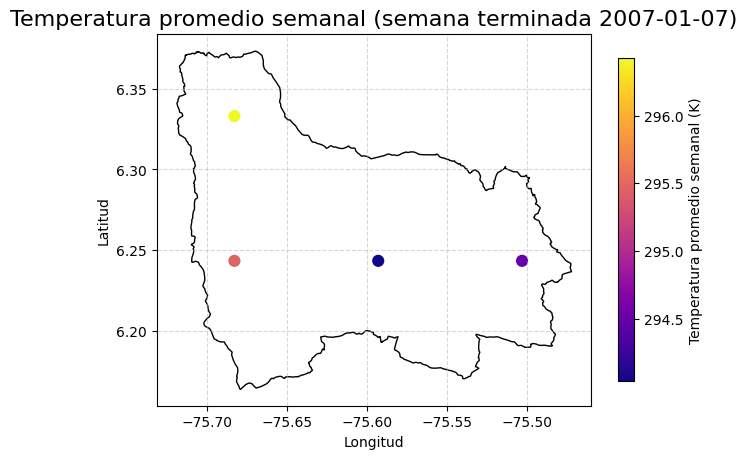

In [26]:
# Filtrar la primera semana disponible en df_weekly
first_week = df_weekly["DATE"].min()
df_week = df_weekly[df_weekly["DATE"] == first_week]

# Convertir a GeoDataFrame
gdf_week = gpd.GeoDataFrame(
    df_week,
    geometry=df_week.LON_LAT,
    crs="EPSG:4326"
)

# Graficar shapefile + puntos con escala de color (temperatura)
fig, ax = plt.subplots(figsize=(7, 6))

# Dibujar municipios
gdf_latlon.plot(ax=ax, facecolor="white", edgecolor="black")

# Dibujar puntos coloreados por temperatura promedio semanal
if 'TEMPERATURE_AVG' in gdf_week.columns:
    temp_col = 'TEMPERATURE_AVG'
else:
    temp_col = gdf_week.columns[gdf_week.columns.str.contains('TEMPERATURE') & gdf_week.columns.str.contains('MAX')][0]

sc = gdf_week.plot(
    ax=ax,
    column=temp_col,
    cmap="plasma",   # escala de colores
    markersize=60,
    legend=True,
    legend_kwds={
        "label": "Temperatura promedio semanal (K)",
        "orientation": "vertical",
        "shrink": 0.7
    }
)

# Ajustes estéticos
plt.title(f"Temperatura promedio semanal (semana terminada {first_week.date()})", fontsize=16)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


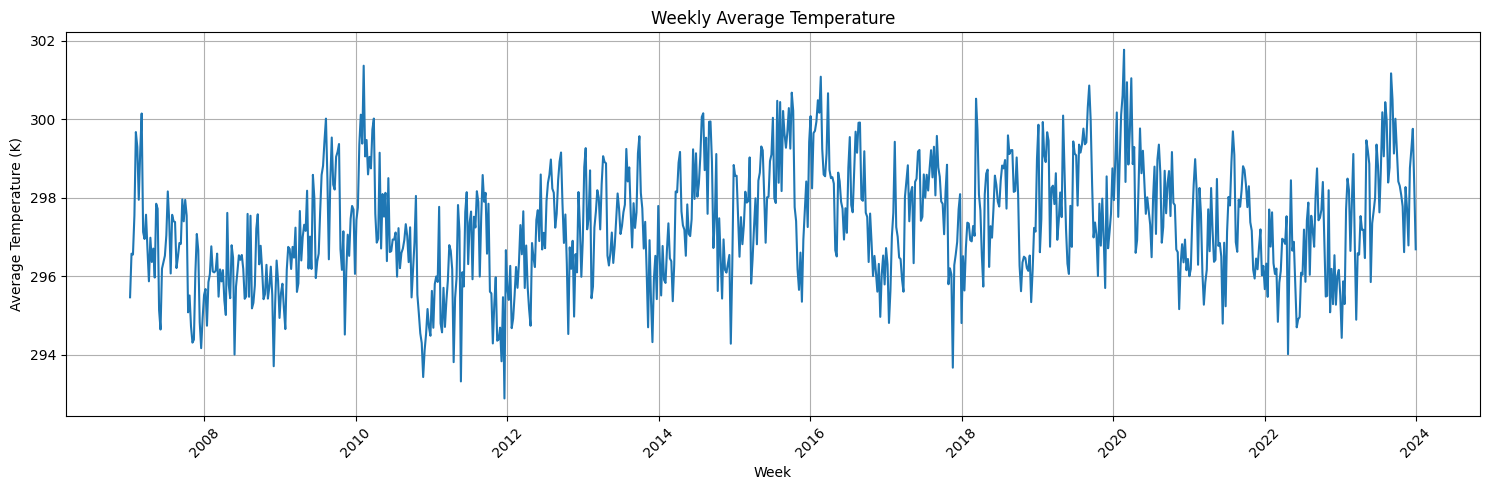

In [27]:
# Step 4: Plot - Temperature time series
plt.figure(figsize=(15,5))

# Find temperature column
if 'TEMPERATURE_MAX' in df_weekly.columns:
    temp_col = 'TEMPERATURE_MAX'
else:
    temp_col = df_weekly.columns[df_weekly.columns.str.contains('TEMPERATURE') & df_weekly.columns.str.contains('AVG')][0]

plt.plot(df_weekly[df_weekly["ID"] == 0].DATE, df_weekly[df_weekly["ID"] == 0][temp_col])
plt.xlabel('Week')
plt.ylabel('Average Temperature (K)')
plt.title('Weekly Average Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()